# Import Packages and Files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV


from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score

import time
import warnings
warnings.filterwarnings("ignore")

In [9]:
# import data files
train = pd.read_csv('application_train.csv')
print('train: ', train.shape)

test = pd.read_csv('application_test.csv')
print('test: ', test.shape)

previous_application = pd.read_csv('previous_application.csv')
print('previous_application: ', previous_application.shape)

bureau_balance = pd.read_csv('bureau_balance.csv')
print('bureau_balance: ', bureau_balance.shape)

bureau = pd.read_csv('bureau.csv')
print('bureau: ', bureau.shape)

credit_card_balance = pd.read_csv('credit_card_balance.csv')
print('credit_card_balance: ', credit_card_balance.shape)

POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
print('POS_CASH_balance: ', POS_CASH_balance.shape)

installments_payments = pd.read_csv('installments_payments.csv')
print('installments_payments: ', installments_payments.shape)

train:  (307511, 122)
test:  (48744, 121)
previous_application:  (1670214, 37)
bureau_balance:  (27299925, 3)
bureau:  (1716428, 17)
credit_card_balance:  (3840312, 23)
POS_CASH_balance:  (10001358, 8)
installments_payments:  (13605401, 8)


In [ ]:
v = train['TARGET'].value_counts()
x = np.arange(len(v))
y = v.values
plt.bar(np.arange(len(v)), y,color=['tab:blue','orange' ]) 
plt.xticks(x, [0,1])
plt.xlabel('TARGET')
plt.ylabel('cnt')
plt.ylim(0, 310000)

for i, v in enumerate(y):
    plt.text( i -.1, v, s=str(v),fontsize=15)
plt.show()

print('{}% of the data are target=0'.format(round(len(train[train['TARGET']==0])/len(train)*100,2)),'; {}% of the data are target=1.'.format(round(len(train[train['TARGET']==1])/len(train)*100,2)))


#The data is imbalanced

# Data Cleaning & Feature Engineering

In [2]:
def one_hot_encoder(df):
    
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    cat_ohe = ohe.fit_transform(df[categorical_columns]).toarray()
    
    # concat the numerical columns and tranformed catrgorical columns
    df_new = df.drop(categorical_columns, axis=1)
    df_new2 = pd.DataFrame(cat_ohe, columns=ohe.get_feature_names_out())
    df_all = pd.concat([df_new, df_new2], axis=1)
    new_columns = [c for c in df_all.columns if c not in original_columns]
    
    return df_all, new_columns 

In [3]:
def application_preprocessing(train, test):
    
    train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
    train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
    train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
    train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']

    test['CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
    test['ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
    test['CREDIT_TERM'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
    test['DAYS_EMPLOYED_PERCENT'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']

    categorical_columns = [col for col in train.columns if train[col].dtype == 'object']
    
    class_dict = {}
    for i in categorical_columns:
        le = LabelEncoder()
        train[i] = le.fit_transform(train[i])
        class_dict[i] = list(le.classes_)
        test[i] = le.transform(test[i])
        
    return train, test

#    return train_poly, test_poly

In [4]:
def previous_application_preprocessing(df):
    
    df, cat_cols = one_hot_encoder(df)
    df['DAYS_FIRST_DRAWING'].max()
    df['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    df['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    df['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    df['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    df['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    df['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    df['APP_CREDIT_PERC'] = df['AMT_CREDIT']/df['AMT_APPLICATION'] 

    num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean'],
        'AMT_APPLICATION': [ 'max','mean'],
        'AMT_CREDIT': [ 'max', 'mean'],
        'APP_CREDIT_PERC': [ 'max', 'mean'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean'],
        'AMT_GOODS_PRICE': [ 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean'],
        'DAYS_DECISION': [ 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
        
    df_agg = df.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    df_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = df[df['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    df_agg = df_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = df[df['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    df_agg = df_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    return df_agg

In [5]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance_preprocessing(bureau_balance, bureau):

    bb, bb_cat = one_hot_encoder(bureau_balance)
    bureau, bureau_cat = one_hot_encoder(bureau)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': [ 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    
    return bureau_agg

In [6]:
def credit_card_balance_preprocessing(cc):
    
    cc, cat_cols = one_hot_encoder(cc)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    return cc_agg

In [7]:
def pos_cash_preprocessing(pos):
   
    pos, cat_cols = one_hot_encoder(pos)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    return pos_agg

In [8]:
def installments_payments_preprocessing(ins):
    
    ins, cat_cols = one_hot_encoder(ins)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum','min','std' ],
        'DBD': ['max', 'mean', 'sum','min','std'],
        'PAYMENT_PERC': [ 'max','mean',  'var','min','std'],
        'PAYMENT_DIFF': [ 'max','mean', 'var','min','std'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum','min','std'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum','std'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum','std']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    return ins_agg

In [10]:
# data preprocessing for every dataset
train, test = application_preprocessing(train, test)
previous_application = previous_application_preprocessing(previous_application)
bureau_and_balance = bureau_and_balance_preprocessing(bureau_balance, bureau)
credit_card_balance = credit_card_balance_preprocessing(credit_card_balance)
pos_cash = pos_cash_preprocessing(POS_CASH_balance)
installments_payments = installments_payments_preprocessing(installments_payments)

In [11]:
## merge dataset using ID
df_train = train.join(bureau_and_balance, how='left', on='SK_ID_CURR')
df_train = df_train.join(previous_application, how='left', on='SK_ID_CURR')
df_train = df_train.join(pos_cash, how='left', on='SK_ID_CURR')
df_train = df_train.join(installments_payments, how='left', on='SK_ID_CURR')
df_train = df_train.join(credit_card_balance, how='left', on='SK_ID_CURR')

df_test = test.join(bureau_and_balance, how='left', on='SK_ID_CURR')
df_test = df_test.join(previous_application, how='left', on='SK_ID_CURR')
df_test = df_test.join(pos_cash, how='left', on='SK_ID_CURR')
df_test = df_test.join(installments_payments, how='left', on='SK_ID_CURR')
df_test = df_test.join(credit_card_balance, how='left', on='SK_ID_CURR')

# Train Test Split

In [12]:
X = df_train.drop('TARGET', axis=1)
y = df_train['TARGET']

X_t = df_test.copy()

In [14]:
import re
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_t= X_t.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

# CatBoost

In [16]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
import gc

In [26]:
clf_catboost = CatBoostClassifier(iterations=2000,
                              learning_rate=0.05,
                              depth=6,
                              l2_leaf_reg=40,
                              bootstrap_type='Bernoulli',
                              subsample=0.7,
                              scale_pos_weight=5,
                              eval_metric='AUC',
                              metric_period=50,
                              od_type='Iter',
                              od_wait=45,
                              random_seed=17,
                              allow_writing_files=False)

clf_catboost.fit(X_train,y_train,verbose=True)

0:	total: 229ms	remaining: 7m 38s
50:	total: 5.96s	remaining: 3m 47s
100:	total: 11.5s	remaining: 3m 36s
150:	total: 16.5s	remaining: 3m 21s
200:	total: 21.2s	remaining: 3m 10s
250:	total: 26s	remaining: 3m 1s
300:	total: 30.8s	remaining: 2m 53s
350:	total: 35.6s	remaining: 2m 47s
400:	total: 40.3s	remaining: 2m 40s
450:	total: 45s	remaining: 2m 34s
500:	total: 49.9s	remaining: 2m 29s
550:	total: 54.7s	remaining: 2m 23s
600:	total: 59.4s	remaining: 2m 18s
650:	total: 1m 4s	remaining: 2m 13s
700:	total: 1m 9s	remaining: 2m 8s
750:	total: 1m 14s	remaining: 2m 3s
800:	total: 1m 18s	remaining: 1m 57s
850:	total: 1m 23s	remaining: 1m 52s
900:	total: 1m 28s	remaining: 1m 47s
950:	total: 1m 32s	remaining: 1m 42s
1000:	total: 1m 37s	remaining: 1m 37s
1050:	total: 1m 42s	remaining: 1m 32s
1100:	total: 1m 46s	remaining: 1m 27s
1150:	total: 1m 51s	remaining: 1m 22s
1200:	total: 1m 56s	remaining: 1m 17s
1250:	total: 2m 1s	remaining: 1m 12s
1300:	total: 2m 5s	remaining: 1m 7s
1350:	total: 2m 10s	re

In [27]:
y_train_predict = clf_catboost.predict(X_train)
y_test_predict =clf_catboost.predict(X_test)


print('AUC:', roc_auc_score(y_test, clf_catboost.predict_proba(X_test)[:,1]))


AUC: 0.7924196432640053


108

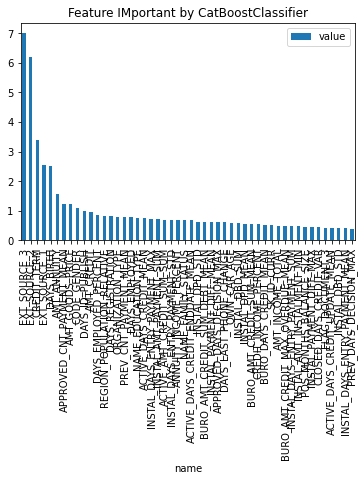

In [19]:
imp = clf_catboost.feature_importances_
col_name = X_train.columns
d2 = {'name': col_name,'value':imp}
d2 = pd.DataFrame(data =d2)
d2 = d2.sort_values(['value'], ascending=False)
temp = d2.set_index('name')
temp[:50].plot(kind='bar',title="Feature IMportant by CatBoostClassifier")
del clf_catboost, temp
gc.collect()

In [20]:
features_selected = d2['name'].tolist()[0:30]
features_selected

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'CREDIT_TERM',
 'EXT_SOURCE_1',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'APPROVED_CNT_PAYMENT_MEAN',
 'AMT_GOODS_PRICE',
 'CODE_GENDER',
 'DAYS_ID_PUBLISH',
 'AMT_CREDIT',
 'DAYS_EMPLOYED_PERCENT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'ORGANIZATION_TYPE',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_EMPLOYED',
 'NAME_EDUCATION_TYPE',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_AMT_PAYMENT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_STD',
 'ANNUITY_INCOME_PERCENT',
 'NAME_FAMILY_STATUS',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'INSTAL_DPD_STD',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'APPROVED_DAYS_DECISION_MAX']

In [21]:
X_train1=X_train[features_selected]
X_train1

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_TERM,EXT_SOURCE_1,DAYS_BIRTH,AMT_ANNUITY,APPROVED_CNT_PAYMENT_MEAN,AMT_GOODS_PRICE,CODE_GENDER,DAYS_ID_PUBLISH,AMT_CREDIT,DAYS_EMPLOYED_PERCENT,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,ORGANIZATION_TYPE,PREV_CNT_PAYMENT_MEAN,DAYS_EMPLOYED,NAME_EDUCATION_TYPE,ACTIVE_DAYS_CREDIT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_AMT_PAYMENT_SUM,ACTIVE_AMT_CREDIT_SUM_SUM,INSTAL_DAYS_ENTRY_PAYMENT_STD,ANNUITY_INCOME_PERCENT,NAME_FAMILY_STATUS,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,INSTAL_DPD_STD,BURO_AMT_CREDIT_SUM_DEBT_MEAN,INSTAL_PAYMENT_DIFF_MEAN,APPROVED_DAYS_DECISION_MAX
123473,0.563835,0.358568,0.029475,0.524685,-23349,16366.5,23.142857,463500.0,0,-4408,555273.0,-15.642768,0.035792,-3595.0,57,23.142857,365243,4,-884.250000,-3.0,1860089.130,1200412.8,830.869265,0.095711,5,326.750000,1.706967,6.472181e+04,260.422638,-450.0
10118,0.595456,0.490305,0.119335,0.244926,-10921,23638.5,9.333333,171000.0,1,-3399,198085.5,0.010713,0.010032,-4281.0,4,8.500000,-117,4,-698.750000,-618.0,447502.950,461254.5,391.061869,0.150086,1,10032.000000,3.231340,1.877032e+04,-2955.460909,-882.0
64716,0.706205,0.643404,0.032427,NaN,-23213,25173.0,14.307692,648000.0,1,-5009,776304.0,0.092922,0.035792,-5680.0,42,14.000000,-2157,3,NaN,-52.0,1033750.980,NaN,1007.594653,0.186467,0,NaN,0.758310,0.000000e+00,-159.598676,-175.0
234940,0.506484,0.426431,0.040875,0.288642,-10703,36787.5,14.857143,900000.0,1,-2751,900000.0,0.236382,0.030755,-2618.0,47,21.000000,-2530,4,-413.333333,-35.0,644220.675,1977390.0,841.413024,0.224132,1,1124.666667,7.427638,2.345008e+05,477.450000,-83.0
236051,0.528093,0.445701,0.039901,0.790210,-15798,21294.0,6.000000,477000.0,1,-5001,533668.5,0.222813,0.025164,-8006.0,16,6.000000,-3520,4,-479.750000,-19.0,469257.210,4083498.0,795.822126,0.094640,1,11774.500000,0.431795,4.084481e+05,107.142857,-705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,NaN,0.617180,0.048300,NaN,-14481,32602.5,12.000000,675000.0,0,-4134,675000.0,0.077619,0.006305,-3813.0,42,15.000000,-1124,4,NaN,-188.0,68873.355,NaN,114.352591,0.268333,3,NaN,0.000000,NaN,0.000000,-564.0
259178,0.370650,0.722398,0.079265,0.455170,-15492,40419.0,17.500000,472500.0,0,-4465,509922.0,0.018848,0.003069,-1613.0,51,18.800000,-292,4,-939.000000,-14.0,943928.910,2587500.0,323.415618,0.179640,1,486.000000,0.000000,2.111378e+05,0.000000,-65.0
131932,0.554947,0.608427,0.029356,0.305919,-14309,33025.5,7.333333,1125000.0,1,-5123,1125000.0,0.414355,0.014520,-5038.0,42,7.333333,-5929,1,-485.250000,-107.0,269576.505,11655697.5,921.547358,0.073390,3,1246.333333,1.000000,8.292967e+05,973.839375,-234.0
146867,0.259468,0.597959,0.050000,0.611373,-12706,13500.0,6.000000,270000.0,1,-4406,270000.0,0.147017,0.010006,-923.0,4,6.000000,-1868,4,-709.250000,-119.0,364838.895,11478330.0,204.225250,0.075000,1,3552.250000,0.000000,2.350190e+06,0.000000,-265.0


In [22]:
clf_catboost0 = CatBoostClassifier(iterations=2000,
                              learning_rate=0.05,
                              depth=6,
                              l2_leaf_reg=40,
                              bootstrap_type='Bernoulli',
                              subsample=0.7,
                              scale_pos_weight=5,
                              eval_metric='AUC',
                              metric_period=50,
                              od_type='Iter',
                              od_wait=45,
                              random_seed=17,
                              allow_writing_files=False)

clf_catboost0.fit(X_train1,y_train,verbose=True)

0:	total: 24.6ms	remaining: 49.1s
50:	total: 900ms	remaining: 34.4s
100:	total: 1.78s	remaining: 33.4s
150:	total: 2.67s	remaining: 32.7s
200:	total: 3.54s	remaining: 31.7s
250:	total: 4.37s	remaining: 30.5s
300:	total: 5.2s	remaining: 29.3s
350:	total: 6.09s	remaining: 28.6s
400:	total: 6.99s	remaining: 27.9s
450:	total: 7.9s	remaining: 27.1s
500:	total: 8.81s	remaining: 26.4s
550:	total: 9.79s	remaining: 25.8s
600:	total: 10.7s	remaining: 24.9s
650:	total: 11.7s	remaining: 24.1s
700:	total: 12.6s	remaining: 23.4s
750:	total: 13.4s	remaining: 22.3s
800:	total: 14.3s	remaining: 21.4s
850:	total: 15.1s	remaining: 20.5s
900:	total: 16s	remaining: 19.5s
950:	total: 16.9s	remaining: 18.6s
1000:	total: 17.7s	remaining: 17.7s
1050:	total: 18.6s	remaining: 16.8s
1100:	total: 19.5s	remaining: 15.9s
1150:	total: 20.4s	remaining: 15.1s
1200:	total: 21.4s	remaining: 14.2s
1250:	total: 22.3s	remaining: 13.3s
1300:	total: 23.2s	remaining: 12.4s
1350:	total: 24s	remaining: 11.5s
1400:	total: 24.9s	r

In [24]:
y_train_predict0 = clf_catboost0.predict(X_train1)
y_test_predict0 =clf_catboost0.predict(X_test)


print('AUC:', roc_auc_score(y_test, clf_catboost0.predict_proba(X_test)[:,1]))

AUC: 0.7802982507011986


In [28]:
y_test_pred=clf_catboost.predict_proba(X_t)[:,1]

In [51]:
submission = pd.read_csv('sample_submission.csv')
submission['TARGET'] = y_test_pred
submission['TARGET'] = submission['TARGET'].apply(lambda x: 0 if x <0 else x)
submission.to_csv('submission_cb3.csv', index=False)
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.150839
1,100005,0.442063
2,100013,0.048863
3,100028,0.141875
4,100038,0.394240
